In [317]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_absolute_error
import xgboost as XGBRegressor
import lightgbm as LGBMRegressor
from sklearn.preprocessing import StandardScaler


import xgboost as xgb
import lightgbm as lgb
from scipy.stats import randint, uniform
import joblib
import warnings
warnings.filterwarnings('ignore')

### Load data

In [222]:
train_df = pd.read_csv('2016-09-19_79351_training.csv', parse_dates=['transaction_date'])
mcc_group_definition = pd.read_csv('mcc_group_definition.csv')
transaction_types = pd.read_csv('transaction_types.csv')

train_df.head()

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,dataset_transaction,dataset_user
0,a78884f5e76951188c1e719d4956773a,2016-02-01,DT,NaN,350,training,training
1,b0333294fef6ff1299102a70ad46b126,2016-02-01,DT,NaN,202,training,training
2,7b8d2a2780adae0cd0c248e92c1b28dc,2016-02-01,DT,NaN,291,training,training
3,cc4abaa500f7db4390ae3f02bd36d805,2016-02-01,DT,NaN,214,training,training
4,49b99d1d5ba028566639e8b3eb7c055b,2016-02-01,DT,NaN,272,training,training


In [223]:
# drop dataset_transaction and dataset_user on train_df
train_df = train_df.drop(columns=["dataset_transaction", "dataset_user"])
train_df.head()

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency
0,a78884f5e76951188c1e719d4956773a,2016-02-01,DT,NaN,350
1,b0333294fef6ff1299102a70ad46b126,2016-02-01,DT,NaN,202
2,7b8d2a2780adae0cd0c248e92c1b28dc,2016-02-01,DT,NaN,291
3,cc4abaa500f7db4390ae3f02bd36d805,2016-02-01,DT,NaN,214
4,49b99d1d5ba028566639e8b3eb7c055b,2016-02-01,DT,NaN,272


In [224]:
train_df.isna().sum(), train_df.shape, mcc_group_definition.columns, transaction_types.columns, train_df.columns

(user_id                     0
 transaction_date            0
 transaction_type            0
 mcc_group              150222
 amount_n26_currency         0
 dtype: int64,
 (408546, 5),
 Index(['mcc_group', 'explanation'], dtype='object'),
 Index(['type', 'explanation', 'direction', 'agent'], dtype='object'),
 Index(['user_id', 'transaction_date', 'transaction_type', 'mcc_group',
        'amount_n26_currency'],
       dtype='object'))

In [225]:
missing_types = set(transaction_types['type']) - set(train_df['transaction_type'])
print("Missing types in train_df:", missing_types)

Missing types in train_df: {'DI', 'AL', 'AA', 'AR', 'WEE', 'AU', 'PF', 'WU', 'AE', 'BRU', 'PR', 'AV', 'TBU', 'BUS'}


In [226]:
train_df['transaction_type'].unique()

array(['DT', 'CT', 'DR', 'FT', 'DD', 'PT', 'BBU', 'BUB', 'TUB'],
      dtype=object)

**Insight**: Here are the transaction types we are missing in our train_df: {'PR', 'BRU', 'DI', 'AE', 'PF', 'AV', 'AU', 'AA', 'WEE', 'AL', 'BUS', 'AR', 'WU', 'TBU'}

- Since the N26 customer data was randomly selected or generated it's plausible to assume that we simply don't have these trasaction types.



In [227]:
train_df.rename(columns={"transaction_type": "type"}, inplace=True)

# merge transaction_types['type'] to train_df 
train_df = train_df.merge(transaction_types[['type', 'explanation', 'direction', 'agent']],
                           on='type', how='left')

train_df = train_df.rename(columns={'explanation': 'transaction_explanation'})
train_df.head()

,user_id,transaction_date,type,mcc_group,amount_n26_currency,transaction_explanation,direction,agent
0,a78884f5e76951188c1e719d4956773a,2016-02-01,DT,NaN,350,Debit Transfer,Out,Bank Account
1,b0333294fef6ff1299102a70ad46b126,2016-02-01,DT,NaN,202,Debit Transfer,Out,Bank Account
2,7b8d2a2780adae0cd0c248e92c1b28dc,2016-02-01,DT,NaN,291,Debit Transfer,Out,Bank Account
3,cc4abaa500f7db4390ae3f02bd36d805,2016-02-01,DT,NaN,214,Debit Transfer,Out,Bank Account
4,49b99d1d5ba028566639e8b3eb7c055b,2016-02-01,DT,NaN,272,Debit Transfer,Out,Bank Account


In [228]:
# Merge train_df with mcc_group on 'mcc_group' column
train_df = train_df.merge(mcc_group_definition, on="mcc_group", how="left")

# Rename the column to 'explanation_category_level', we'll see some NaN
train_df.rename(columns={"explanation": "category_level_explanation"}, inplace=True)
train_df['category_level_explanation'].fillna('no category', inplace=True)
train_df['mcc_group'].fillna('no mcc group', inplace=True)
train_df.head()


,user_id,transaction_date,type,mcc_group,amount_n26_currency,transaction_explanation,direction,agent,category_level_explanation
0,a78884f5e76951188c1e719d4956773a,2016-02-01,DT,no mcc group,350,Debit Transfer,Out,Bank Account,no category
1,b0333294fef6ff1299102a70ad46b126,2016-02-01,DT,no mcc group,202,Debit Transfer,Out,Bank Account,no category
2,7b8d2a2780adae0cd0c248e92c1b28dc,2016-02-01,DT,no mcc group,291,Debit Transfer,Out,Bank Account,no category
3,cc4abaa500f7db4390ae3f02bd36d805,2016-02-01,DT,no mcc group,214,Debit Transfer,Out,Bank Account,no category
4,49b99d1d5ba028566639e8b3eb7c055b,2016-02-01,DT,no mcc group,272,Debit Transfer,Out,Bank Account,no category


In [229]:
# replace "category_level_explanation" == no category with the transaction_explanation name
train_df.loc[train_df['category_level_explanation'] == 'no category', 'category_level_explanation'] = train_df.loc[train_df['category_level_explanation'] == 'no category', 'transaction_explanation']

In [230]:
# for dtypes 'O' convert them to strings
columns_to_convert = ["transaction_explanation", "direction", "agent", "category_level_explanation", "mcc_group"]

for col in columns_to_convert:
    train_df[col] = train_df[col].astype("string")

### EDA

In [231]:
train_df.head(2)

,user_id,transaction_date,type,mcc_group,amount_n26_currency,transaction_explanation,direction,agent,category_level_explanation
0,a78884f5e76951188c1e719d4956773a,2016-02-01,DT,no mcc group,350,Debit Transfer,Out,Bank Account,Debit Transfer
1,b0333294fef6ff1299102a70ad46b126,2016-02-01,DT,no mcc group,202,Debit Transfer,Out,Bank Account,Debit Transfer


1. Extract feature informations from date such as: monht, day
2. Create user month level aggregations (in order to reduce dimensionality while maintaining key information)

In [232]:
train_df['transaction_date'] = pd.to_datetime(train_df['transaction_date'])

# extract to month and date to later be used in vizualizations that might reveal some trends
train_df['month'] = train_df['transaction_date'].dt.month
train_df['day_of_month'] = train_df['transaction_date'].dt.day

Analysing spending by category_level_explanation

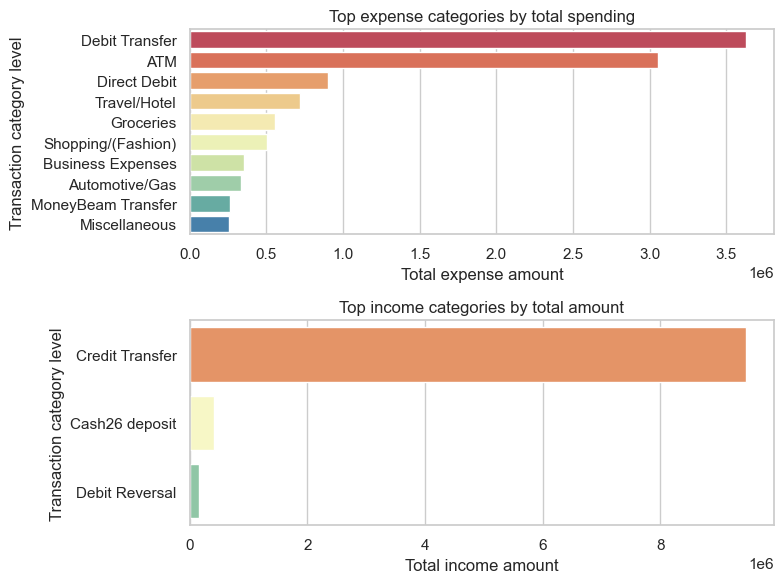

In [233]:
# Top spending (expense) categories
expense_df = monthly_agg[monthly_agg[('direction', '')] == 'Out']
top_expense_categories = (
    expense_df.groupby(('category_level_explanation', ''))
    .agg({('amount_n26_currency', 'sum'): 'sum'})
    .sort_values(by=('amount_n26_currency', 'sum'), ascending=False)
    .head(10)
    .reset_index())

# Top income categories
income_df = monthly_agg[monthly_agg[('direction', '')] == 'In']
top_income_categories = (
    income_df.groupby(('category_level_explanation', ''))
    .agg({('amount_n26_currency', 'sum'): 'sum'})
    .sort_values(by=('amount_n26_currency', 'sum'), ascending=False)
    .head(10)
    .reset_index())

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# plot expenses
sns.barplot(
    x=top_expense_categories[('amount_n26_currency', 'sum')], 
    y=top_expense_categories[('category_level_explanation', '')], 
    palette="Spectral",
    ax=ax1)

ax1.set_xlabel("Total expense amount")
ax1.set_ylabel("Transaction category level")
ax1.set_title("Top expense categories by total spending")

# income
sns.barplot(
    x=top_income_categories[('amount_n26_currency', 'sum')], 
    y=top_income_categories[('category_level_explanation', '')], 
    palette="Spectral",
    ax=ax2)
    
ax2.set_xlabel("Total income amount")
ax2.set_ylabel("Transaction category level")
ax2.set_title("Top income categories by total amount")

plt.tight_layout()
plt.show()

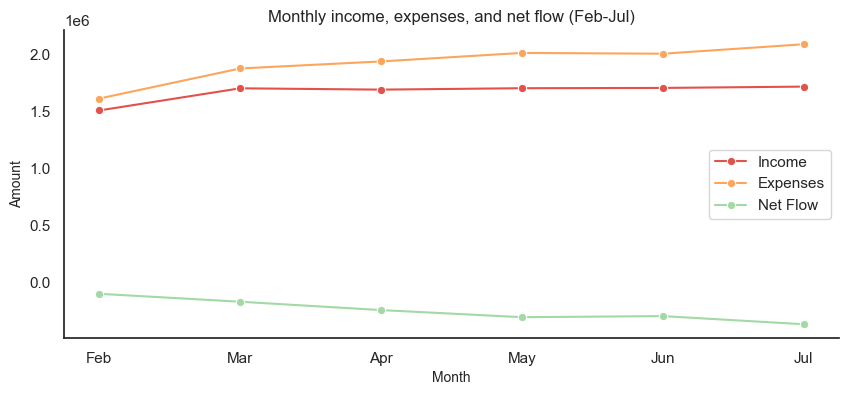

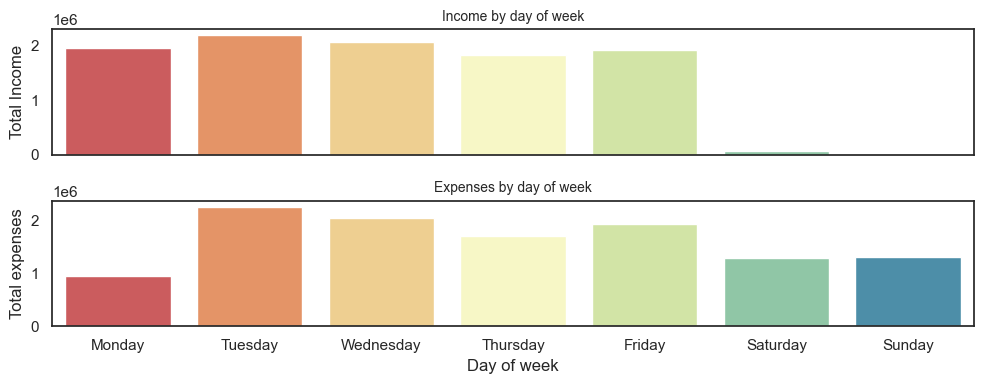

In [234]:
train_df['day_of_week'] = train_df['transaction_date'].dt.dayofweek + 1  # 1 = Monday, 7 = Sunday

# Split income and expenses
income_df = train_df[train_df['direction'] == 'In']
expense_df = train_df[train_df['direction'] == 'Out']

# Monthly income/expense patterns
monthly_income = income_df.groupby('month')['amount_n26_currency'].sum().reset_index()
monthly_expense = expense_df.groupby('month')['amount_n26_currency'].sum().reset_index()

monthly_comparison = pd.merge(monthly_income, monthly_expense, on='month', suffixes=('_income', '_expense'))
monthly_comparison['net_flow'] = (monthly_comparison['amount_n26_currency_income'] - monthly_comparison['amount_n26_currency_expense'])

month_labels = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul']

colors = sns.color_palette("Spectral", 6)
sns.set_theme(style="white") 

# Monthly income, expenses, and net flow
plt.figure(figsize=(10, 4))
sns.lineplot(x=monthly_comparison['month'], y=monthly_comparison['amount_n26_currency_income'], marker='o', label='Income', color=colors[0])
sns.lineplot(x=monthly_comparison['month'], y=monthly_comparison['amount_n26_currency_expense'], marker='o', label='Expenses', color=colors[1])
sns.lineplot(x=monthly_comparison['month'], y=monthly_comparison['net_flow'], marker='o', label='Net Flow', color=colors[4])

plt.title('Monthly income, expenses, and net flow (Feb-Jul)', fontsize=12)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Amount', fontsize=10)
plt.xticks(ticks=range(2, 8), labels=month_labels)
plt.legend()
sns.despine()
plt.show()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

daily_income['day_of_week'] = pd.Categorical(daily_income['day_of_week'], categories=range(1, 8), ordered=True)
daily_expense['day_of_week'] = pd.Categorical(daily_expense['day_of_week'], categories=range(1, 8), ordered=True)

daily_income = daily_income.sort_values('day_of_week')
daily_expense = daily_expense.sort_values('day_of_week')

fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

# Income plot
sns.barplot(x=daily_income['day_of_week'], y=daily_income['amount_n26_currency'], ax=axes[0], palette="Spectral")
axes[0].set_title('Income by day of week', fontsize=10)
axes[0].set_ylabel('Total Income')
axes[0].set_xticklabels(day_order) 

# Expense plot
sns.barplot(x=daily_expense['day_of_week'], y=daily_expense['amount_n26_currency'], ax=axes[1], palette="Spectral")
axes[1].set_title('Expenses by day of week', fontsize=10)
axes[1].set_ylabel('Total expenses')
axes[1].set_xlabel('Day of week')
axes[1].set_xticklabels(day_order)  

plt.tight_layout()
plt.show()

**Insights**: 
- As we know from economics, the more the income is increased, the more the expenses are as well.
- Expenses are risen as we go into the months of July, probably becasue of the vacations.
- Regarding weekdays, we see during the weekends people have considerably higher expenses than income and it makes sense.



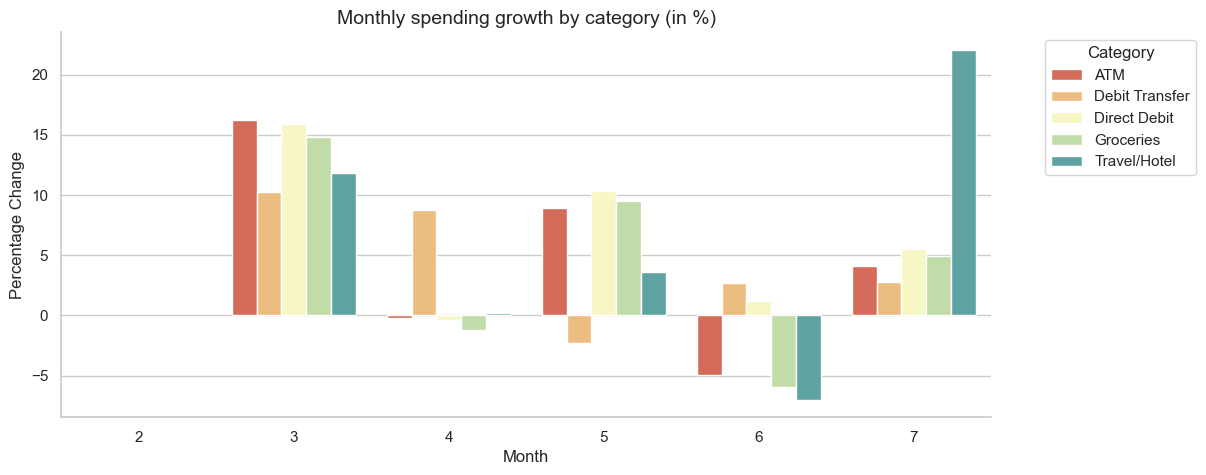

In [235]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style
sns.set_theme(style="whitegrid")

# Get top 5 categories by expense count
top5_expense_cats = expense_df['category_level_explanation'].value_counts().head(5).index.tolist()
top5_cat_data = expense_df[expense_df['category_level_explanation'].isin(top5_expense_cats)]

# Compute monthly spending growth
cat_monthly = top5_cat_data.pivot_table(index='month', columns='category_level_explanation', values='amount_n26_currency', aggfunc='sum')
cat_monthly_pct = cat_monthly.pct_change() * 100 

# Convert to long format for seaborn
cat_monthly_pct = cat_monthly_pct.reset_index().melt(id_vars='month', var_name='Category', value_name='Growth (%)')

# Plot using seaborn
plt.figure(figsize=(12, 5))
ax = sns.barplot(
    data=cat_monthly_pct,
    x='month',
    y='Growth (%)',
    hue='Category',
    palette='Spectral')

# Improve presentation
plt.title('Monthly spending growth by category (in %)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Percentage Change', fontsize=12)
plt.xticks(rotation=0)  # Keep x-axis readable
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()  # Remove top and right borders

plt.show()


**Insights**: 
- Noticably on the month of July there is a big spike on mcc_Travel/Hotel category as it plays the picture of people booking vacations.
- The mcc_Groceries have similar patterns with peaks in March, May, and July but decline in April and June. The drop in June suggests lower grocery and cash withdrawals that month.
- DD_Direct_Debit overall remains stable.

In [236]:
direction_counts = train_df['direction'].value_counts()
direction_percentage = (direction_counts / direction_counts.sum()) * 100
direction_percentage

direction
Out    82.345929
In     17.654071
Name: count, dtype: Float64

We notice that 82.34% of the users perform expense transactional and the rest (17.65%) comes from income transactions

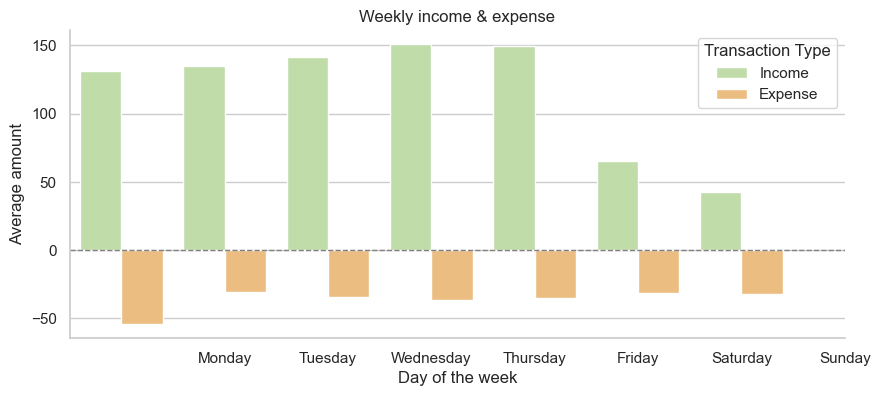

In [237]:
# Compute weekly income & expense
weekly_income = train_df[train_df['direction'] == "In"].groupby('day_of_week')['amount_n26_currency'].mean().reset_index()
weekly_expense = train_df[train_df['direction'] == "Out"].groupby('day_of_week')['amount_n26_currency'].mean().reset_index()

# Ensure Sunday is in the correct place
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_income['day_of_week'] = pd.Categorical(weekly_income['day_of_week'], categories=range(1, 8), ordered=True)
weekly_expense['day_of_week'] = pd.Categorical(weekly_expense['day_of_week'], categories=range(1, 8), ordered=True)

# Sort for correct display
weekly_income = weekly_income.sort_values('day_of_week')
weekly_expense = weekly_expense.sort_values('day_of_week')

# Combine data for Seaborn
weekly_income['type'] = 'Income'
weekly_expense['type'] = 'Expense'
weekly_expense['amount_n26_currency'] *= -1 

weekly_data = pd.concat([weekly_income, weekly_expense])

# Define a reversed Spectral palette to swap colors
swapped_palette = sns.color_palette("Spectral", 2)[::-1]

# Plot with switched colors
plt.figure(figsize=(10, 4))
sns.barplot(
    x=weekly_data['day_of_week'],
    y=weekly_data['amount_n26_currency'],
    hue=weekly_data['type'],
    palette=swapped_palette )

plt.xlabel("Day of the week")
plt.ylabel("Average amount")
plt.title("Weekly income & expense")
plt.xticks(ticks=range(1, 8), labels=day_order)
plt.axhline(0, color='grey', linewidth=1, linestyle='dashed')  
sns.despine()
plt.legend(title="Transaction Type")
plt.show()

**Insights**: 
- As we know from economics, the more the income is increased, the more the expenses are as well.
- Expenses are risen as we go into the months of July, probably becasue of the vacations.
- Regarding weekdays, we see during the weekends people have considerably higher expenses than income and it makes sense.



### Feature engineering

**Features to keep:**
- user_id: Essential for user-level grouping
- direction: Essential for separating In/Out transactions
- amount_n26_currency: The target variable we're trying to predict
- month: Essential for time-based analysis and grouping

In [238]:
train_df.head(2)

,user_id,transaction_date,type,mcc_group,amount_n26_currency,transaction_explanation,direction,agent,category_level_explanation,month,day_of_month,day_of_week
0,a78884f5e76951188c1e719d4956773a,2016-02-01,DT,no mcc group,350,Debit Transfer,Out,Bank Account,Debit Transfer,2,1,1
1,b0333294fef6ff1299102a70ad46b126,2016-02-01,DT,no mcc group,202,Debit Transfer,Out,Bank Account,Debit Transfer,2,1,1


**Transaction Recency:** identify active vs. dormant users
If a user hasn't transacted recently, they might be less likely to have transactions in August or might follow a specific pattern (e.g., transacting only quarterly).

In [239]:
train_df['transaction_date'] = pd.to_datetime(train_df['transaction_date'])
train_df = train_df.sort_values(['user_id', 'direction', 'transaction_date'])
train_df['days_since_last_transaction'] = train_df.groupby(['user_id', 'direction'])['transaction_date'].diff().dt.days
train_df['days_since_last_transaction'] = train_df['days_since_last_transaction'].fillna(0)

**User monthly transaction count:** Reveals how frequently each user typically transacts per month. Users with consistent transaction counts tend to be more predictable, and this pattern is likely to continue into August.

In [240]:
monthly_counts = train_df.groupby(['user_id', 'direction', 'month']).size().reset_index(name='monthly_transaction_count')
train_df = train_df.merge(monthly_counts, on=['user_id', 'direction', 'month'], how='left')

**Transaction amount percentiles:** Shows the distribution of transaction amounts for each user. 
This helps identify typical spending/income patterns and whether a user typically makes many small transactions or fewer large ones, which often continues predictably.

In [241]:
# Calculate percentiles of transaction amounts for each user-direction
percentiles = train_df.groupby(['user_id', 'direction'])['amount_n26_currency'].agg([
    ('amount_25th_percentile', lambda x: x.quantile(0.25)),
    ('amount_median', lambda x: x.quantile(0.5)),
    ('amount_75th_percentile', lambda x: x.quantile(0.75))]).reset_index()

train_df = train_df.merge(percentiles, on=['user_id', 'direction'], how='left')

**Monthy growth:** Captures trends in spending or income over time. 
If a user's transactions have been steadily increasing or decreasing, this trend might continue into August.

In [242]:
# Calculate monthly totals for each user-direction-month combination
monthly_totals = train_df.groupby(['user_id', 'direction', 'month'])['amount_n26_currency'].sum().reset_index()
monthly_totals = monthly_totals.sort_values(['user_id', 'direction', 'month'])

monthly_totals['previous_month_amount'] = monthly_totals.groupby(['user_id', 'direction'])['amount_n26_currency'].shift(1)
monthly_totals['month_to_month_growth'] = ((monthly_totals['amount_n26_currency'] - monthly_totals['previous_month_amount']) / 
                                          monthly_totals['previous_month_amount'] * 100).fillna(0)
train_df = train_df.merge(monthly_totals[['user_id', 'direction', 'month', 'month_to_month_growth']], 
                         on=['user_id', 'direction', 'month'], how='left')

**Cumulative amount:** Provides context on the user's total financial activity. 
Users with higher cumulative amounts might have different spending patterns than those with lower amounts.

In [243]:
train_df = train_df.sort_values(['user_id', 'direction', 'transaction_date'])

# cumulative sum of amount for each user-direction
train_df['cumulative_amount'] = train_df.groupby(['user_id', 'direction'])['amount_n26_currency'].cumsum()

**Regularity score:** Identifies users with consistent transaction timing versus sporadic behavior. 
Regular users (low score) are typically more predictable than irregular ones (high score).

In [244]:
# average and std dev of days between transactions
regularity_metrics = train_df.groupby(['user_id', 'direction'])['days_since_last_transaction'].agg([
    ('avg_days_between_transactions', 'mean'),
    ('regularity_score', 'std')]).reset_index() # Lower std dev means more regular transactions

regularity_metrics['regularity_score'] = regularity_metrics['regularity_score'].fillna(regularity_metrics['regularity_score'].max())
train_df = train_df.merge(regularity_metrics, on=['user_id', 'direction'], how='left')

In [245]:
train_df.head(2)

,user_id,transaction_date,type,mcc_group,amount_n26_currency,transaction_explanation,direction,agent,category_level_explanation,month,...,day_of_week,days_since_last_transaction,monthly_transaction_count,amount_25th_percentile,amount_median,amount_75th_percentile,month_to_month_growth,cumulative_amount,avg_days_between_transactions,regularity_score
0,000295594379774ab9ac2c78c946d615,2016-02-19,CT,no mcc group,291,Credit Transfer,In,Bank Account,Credit Transfer,2,...,5,0.0,1,145.0,223.0,313.5,0.000000,291,26.25,25.979158
1,000295594379774ab9ac2c78c946d615,2016-03-09,CT,no mcc group,381,Credit Transfer,In,Bank Account,Credit Transfer,3,...,3,19.0,1,145.0,223.0,313.5,30.927835,672,26.25,25.979158


At this point, our train_df is enriched with many information calulated, but before building the model let's evaluating the features we created.

How they are perfoming, are they adding value to our dataset or will the add potential value to the models?


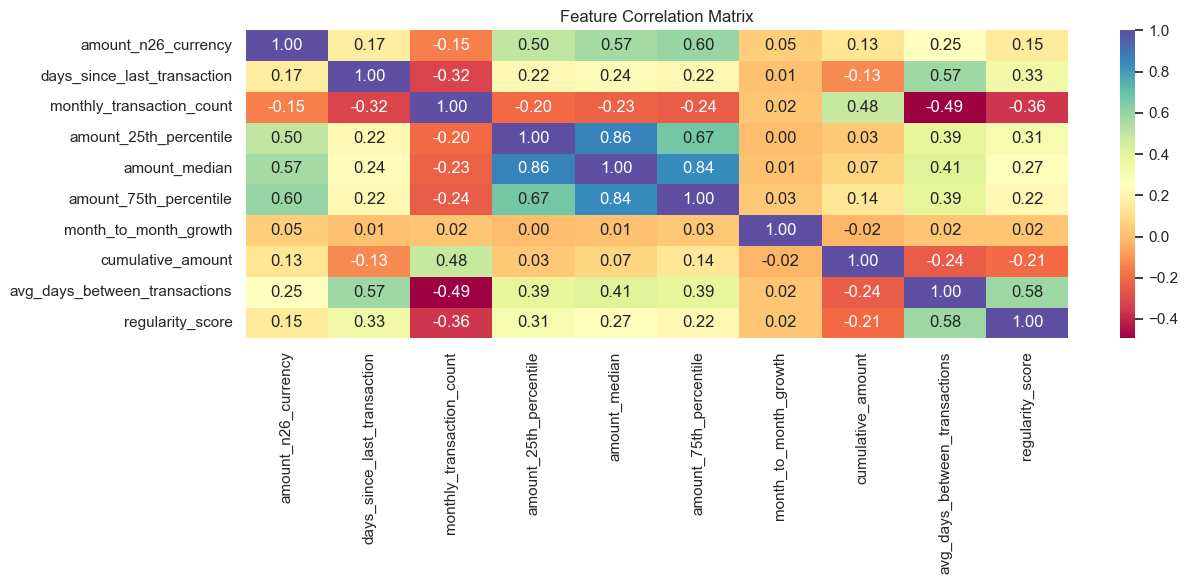

In [264]:
# simple correlation analysis

numeric_df = train_df.select_dtypes(include=['float64', 'int64'])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(13, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Spectral', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()

**Corr matrix insight:**
First, there's a strong correlation between the percentile features, suggesting potential redundancy - we might perhaps keep just the median and remove the others. Second, the `month_to_month_growth` shows surprisingly low correlation with all other features, indicating it captures unique information not represented elsewhere. Finally, there's a moderate negative relationship between `monthly_transaction_count` and `avg_days_between_transactions` (-0.49), which makes logical sense as more frequent transactions mean fewer days between them.

In [266]:
# Feature importance analysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# exclude non feature columns and leave only the ones we calculated in the feature engineering part
X = train_df.drop(['amount_n26_currency', 'user_id', 'transaction_date', 'type', 
                  'mcc_group', 'transaction_explanation', 'agent', 
                  'category_level_explanation', 'direction'], axis=1)
y = train_df['amount_n26_currency']

# Random Forest model trainign
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# feature importance
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_}).sort_values('Importance', ascending=False)

print("Random Forest Feature Importance:")
print(rf_importance)

# permutation importance
result = permutation_importance(
    rf_model, X, y, 
    n_repeats=10,
    random_state=42)

perm_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std}).sort_values('Importance', ascending=False)

print("\nPermutation Importance:")
print(perm_importance)

# rankings
rf_ranks = {feature: rank+1 for rank, feature in enumerate(rf_importance['Feature'])}
perm_ranks = {feature: rank+1 for rank, feature in enumerate(perm_importance['Feature'])}

comparison = []
for feature in X.columns:
    comparison.append({
        'Feature': feature,
        'RF_Rank': rf_ranks.get(feature, 0),
        'Perm_Rank': perm_ranks.get(feature, 0),
        'Avg_Rank': (rf_ranks.get(feature, 0) + perm_ranks.get(feature, 0)) / 2})

comparison_df = pd.DataFrame(comparison).sort_values('Avg_Rank')
print("\nFeatures sorted by average rank:")
print(comparison_df)

Random Forest Feature Importance:
                          Feature  Importance
7          amount_75th_percentile    0.356763
9               cumulative_amount    0.162336
6                   amount_median    0.077360
8           month_to_month_growth    0.074547
1                    day_of_month    0.065372
3     days_since_last_transaction    0.057046
4       monthly_transaction_count    0.045065
5          amount_25th_percentile    0.037829
10  avg_days_between_transactions    0.034796
11               regularity_score    0.032949
2                     day_of_week    0.030425
0                           month    0.025513

Permutation Importance:
                          Feature  Importance       Std
9               cumulative_amount    1.699002  0.005824
7          amount_75th_percentile    0.712412  0.001915
4       monthly_transaction_count    0.696946  0.002414
8           month_to_month_growth    0.384723  0.001801
0                           month    0.279176  0.000853
1      

In [267]:
# now that we identifies important features to keep we can dropp the ones that scored low as per the avg_rang like: amount_25th_percentile, regularity_score, day_of_week, avg_days_between_transactions
# month we'll not drop it since we'll group by months later for dataset split based on direction and user_id

drop_features = ['avg_days_between_transactions', 'amount_25th_percentile', 'regularity_score', 'day_of_week']
train_df = train_df.drop(drop_features, axis=1)

`Log transformation` is ideal for financial data for several reasons:

- **Handles positive skew effectively**: Log transforms are specifically designed for right-skewed data with a long tail, which perfectly aligns with financial transactions nature.
- **Preserves relative differences**: A jump from 10EUR to 20EUR (100% increase) is treated similarly to a jump from 100EUR to 200EUR (also 100% increase), which makes sense for financial data.
- **Aligns with financial logic**: In finance, we often think in terms of percentage increase or decrease changes than absolute changes (|x|), which log transformation perfectly accommodates.
- **Reveals patterns**: The multimodal distribution in the log-transformed data reveals transaction patterns that were  hidden in the original distribution.
- **Improves in general model performance**: Most machine learning algorithms perform better with normally-distributed features.

Naturally you would ask why not `Exponential` or other transformations?

- Exponential transform would make the skew worse, not better (it would stretch the right tail even further).
- Square root transform would help but not enough for such extreme skew.
- Box-Cox transform could work but is more complex and would likely choose a parameter close to zero (equivalent to log).

### Dataset group by direction per user level

In [272]:
# aggregate to monthly level by user and direction
train_df = train_df.groupby(['user_id', 'month', 'direction']).agg({
    'amount_n26_currency': 'sum',
    'amount_75th_percentile': 'first',
    'cumulative_amount': 'max',
    'month_to_month_growth': 'first',
    'monthly_transaction_count': 'first',
    'day_of_month': 'mean',
    'amount_median': 'first',
    'days_since_last_transaction': 'mean'}).reset_index()


In [275]:
train_df.head(2)

,user_id,month,direction,amount_n26_currency,amount_75th_percentile,cumulative_amount,month_to_month_growth,monthly_transaction_count,day_of_month,amount_median,days_since_last_transaction
0,000295594379774ab9ac2c78c946d615,2,In,291,313.50,291,0.0,1,19.0,223.0,0.0
1,000295594379774ab9ac2c78c946d615,2,Out,280,33.25,280,0.0,1,21.0,10.0,0.0


#### Create income and expense dfs and perform split (train and validation)

In [276]:
# Split into income and expense dfs
income_df = monthly_agg[monthly_agg['direction'] == 'In'].copy()
expense_df = monthly_agg[monthly_agg['direction'] == 'Out'].copy()

# drop the direction column as it's now redundant
income_df = income_df.drop('direction', axis=1)
expense_df = expense_df.drop('direction', axis=1)

In [277]:
# split into training and validation sets
train_income = income_df[income_df['month'] < 7]
valid_income = income_df[income_df['month'] == 7] # july for validation

train_expense = expense_df[expense_df['month'] < 7]
valid_expense = expense_df[expense_df['month'] == 7] #  july for validation

In [280]:
# Prepare X and y for training

# INCOME df
X_train_income = train_income.drop(['amount_n26_currency', 'user_id'], axis=1)
y_train_income = np.log1p(train_income['amount_n26_currency'])  

X_valid_income = valid_income.drop(['amount_n26_currency', 'user_id'], axis=1)
y_valid_income = np.log1p(valid_income['amount_n26_currency'])  

# =============================================================================
# EXPENSE df
X_train_expense = train_expense.drop(['amount_n26_currency', 'user_id'], axis=1)
y_train_expense = np.log1p(train_expense['amount_n26_currency']) 

X_valid_expense = valid_expense.drop(['amount_n26_currency', 'user_id'], axis=1)
y_valid_expense = np.log1p(valid_expense['amount_n26_currency']) 

In [281]:
X_train_income.shape, y_train_income.shape, X_valid_income.shape, y_valid_income.shape, X_train_expense.shape, y_train_expense.shape, X_valid_expense.shape, y_valid_expense.shape

((26986, 8),
 (26986,),
 (5400, 8),
 (5400,),
 (34062, 8),
 (34062,),
 (6851, 8),
 (6851,))

**Income datasets:**
- Training: 26,986 records with 8 features
- Validation: 5,400 records with 8 features

**Expense datasets:**
- Training: 34,062 records with 8 features
- Validation: 6,851 records with 8 features

### Training for income_df

In [288]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# diff models to evaluate
models = {'RandomForest': RandomForestRegressor(random_state=42),
        'GradientBoosting': GradientBoostingRegressor(random_state=42),
        'ElasticNet': ElasticNet(random_state=42),
        'XGBoost': XGBRegressor.XGBRegressor(random_state=42),
        'LightGBM': LGBMRegressor.LGBMRegressor(random_state=42)}

results = {}
for name, model in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    
    cv_scores = cross_val_score(pipe, X_train_income, y_train_income, cv=kf, scoring='r2')
    results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()}
    print(f"{name}: R² = {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Select the best performing model
best_model_name = max(results, key=lambda x: results[x]['cv_mean'])
print(f"\nBest model: {best_model_name}")

RandomForest: R² = 0.9502 (±0.0048)
GradientBoosting: R² = 0.9397 (±0.0045)
ElasticNet: R² = 0.1817 (±0.0024)
XGBoost: R² = 0.9493 (±0.0045)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1542
[LightGBM] [Info] Number of data points in the train set: 21588, number of used features: 8
[LightGBM] [Info] Start training from score 4.988612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 21589, number of used features: 8
[LightGBM] [Info] Start training from score 4.985473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1542
[LightGBM] [Info] Number of data points in the train set: 21588, number of used features: 8
[LightGBM] [Info] Start training from score 4.988612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 21589, number of used features: 8
[LightGBM] [Info] Start training from score 4.985473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 

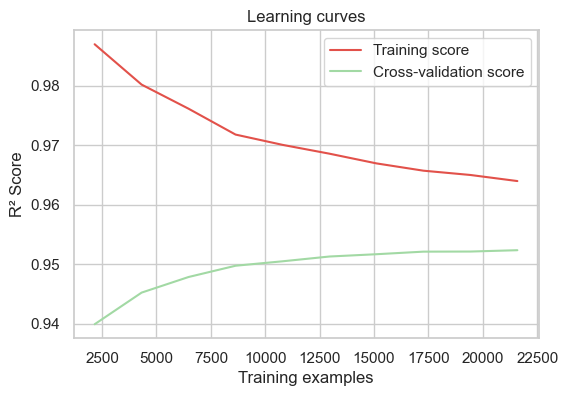

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1542
[LightGBM] [Info] Number of data points in the train set: 21588, number of used features: 8
[LightGBM] [Info] Start training from score 4.988612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 21589, number of used features: 8
[LightGBM] [Info] Start training from score 4.985473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 21589, number of used features: 8
[LightGBM] [Info] Start traini

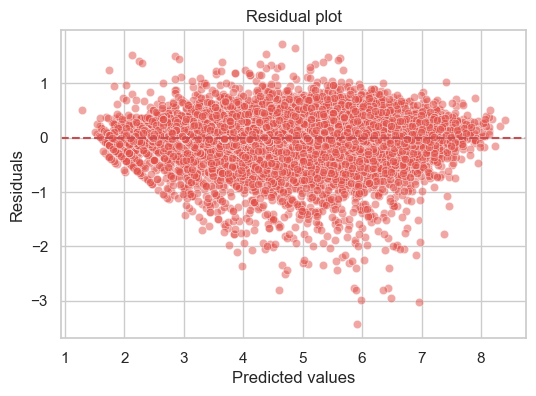

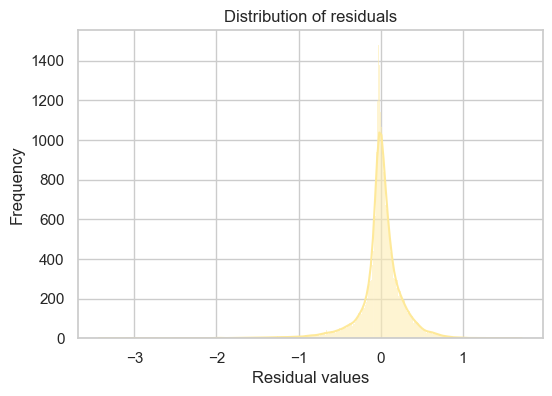

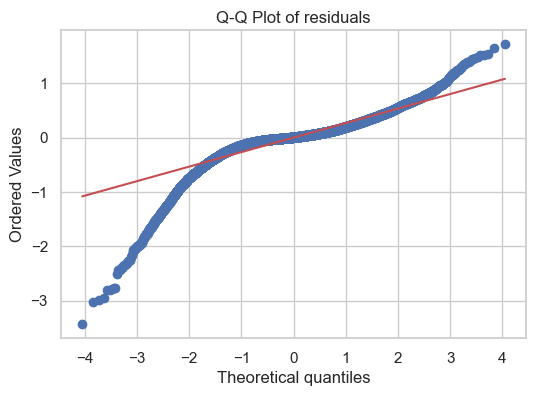

In [315]:
from sklearn.model_selection import cross_val_predict, learning_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_palette("Spectral")

# 1. Compare training and validation performance
train_scores = cross_val_score(pipe, X_train_income, y_train_income, cv=kf, scoring='r2')
print("Training R² scores:", train_scores)
print(f"Training R² mean: {train_scores.mean():.4f} (±{train_scores.std():.4f})")

# 2. Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(pipe, X_train_income, y_train_income, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), 
                                                        cv=kf, 
                                                        scoring='r2')

# Plot learning curves with seaborn and Spectral palette
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score', color=sns.color_palette("Spectral")[0])
plt.plot(train_sizes, valid_scores.mean(axis=1), label='Cross-validation score', color=sns.color_palette("Spectral")[4])
plt.title('Learning curves')
plt.xlabel('Training examples')
plt.ylabel('R² Score')
plt.legend()
plt.show()

# Residual Analysis
y_pred = cross_val_predict(pipe, X_train_income, y_train_income, cv=kf)
residuals = y_train_income - y_pred

plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, palette="Spectral")
plt.title('Residual plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Additional Residual Distribution Analysis
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, color=sns.color_palette("Spectral")[2])
plt.title('Distribution of residuals')
plt.xlabel('Residual values')
plt.ylabel('Frequency')
plt.show()

# Q-Q Plot to check normality of residuals
plt.figure(figsize=(6, 4))
from scipy import stats
stats.probplot(residuals, plot=plt)
plt.title('Q-Q Plot of residuals')
plt.show()


July income data performance metrics:
R²: 0.7360
MAE: 108.65
MAPE: 49.76%
RMSLE: 0.51%


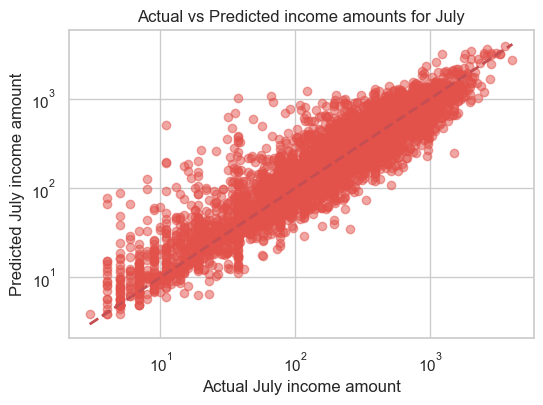

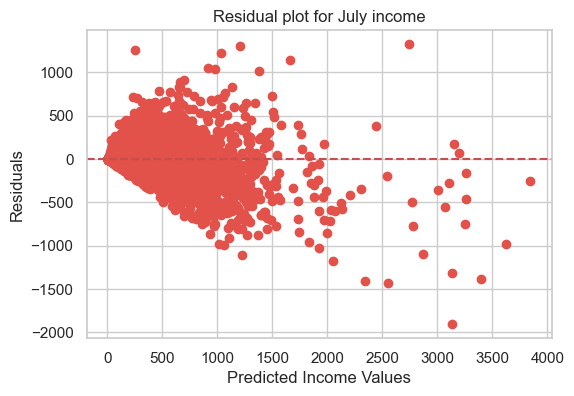

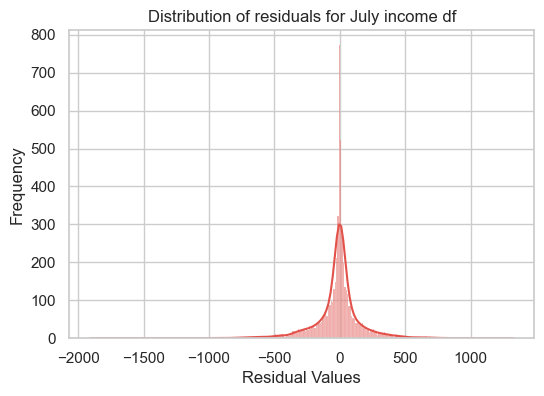

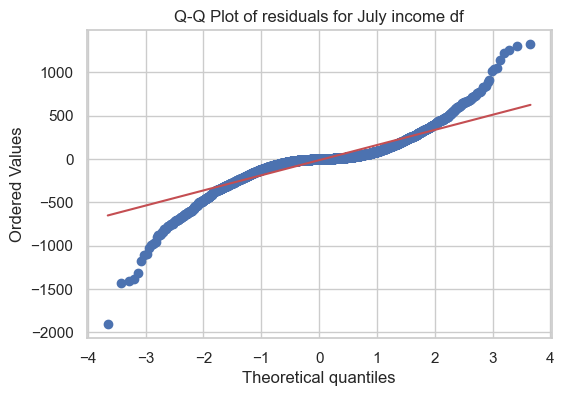


Top Features:
                       feature  importance  cumulative_proportion
2            cumulative_amount         702               0.234000
3        month_to_month_growth         691               0.464333
7  days_since_last_transaction         359               0.584000
1       amount_75th_percentile         342               0.698000
4    monthly_transaction_count         291               0.795000
0                        month         271               0.885333
6                amount_median         222               0.959333
5                 day_of_month         122               1.000000


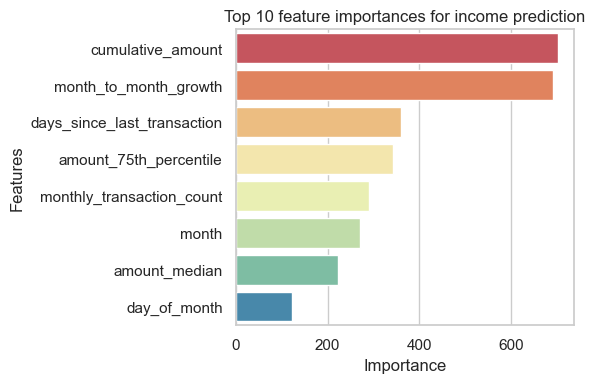

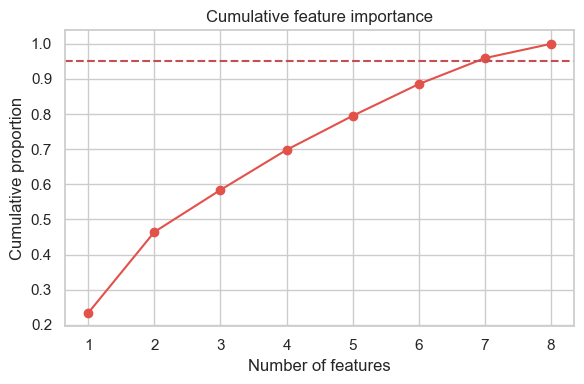

In [316]:
# Prepare July income data for testing
july_income_data = valid_income.copy()

# Prepare features for July income data
X_july_income = july_income_data.drop(['user_id', 'amount_n26_currency'], axis=1)
y_july_income = np.log1p(july_income_data['amount_n26_currency'])

# Preprocess July data using the same pipeline
X_july_income_scaled = pipe.named_steps['scaler'].transform(X_july_income)

# Predict on July income data
y_pred_july_income_log = pipe.named_steps['model'].predict(X_july_income_scaled)
y_pred_july_income = np.expm1(y_pred_july_income_log)
y_july_income_orig = np.expm1(y_july_income)

# Evaluate performance on July income data
r2_july_income = r2_score(y_july_income_orig, y_pred_july_income)
mae_july_income = mean_absolute_error(y_july_income_orig, y_pred_july_income)
mape_july_income = np.mean(np.abs((y_july_income_orig - y_pred_july_income) / (y_july_income_orig + 1))) * 100
rmsle_july_income = np.sqrt(np.mean((y_july_income - y_pred_july_income_log)**2))


print("\nJuly income data performance metrics:")
print(f"R²: {r2_july_income:.4f}")
print(f"MAE: {mae_july_income:.2f}")
print(f"MAPE: {mape_july_income:.2f}%")
print(f"RMSLE: {rmsle_july_income:.2f}%")

# Visualization of actual vs predicted for July Income
plt.figure(figsize=(6, 4))
plt.scatter(y_july_income_orig, y_pred_july_income, alpha=0.5)
plt.plot([y_july_income_orig.min(), y_july_income_orig.max()], 
         [y_july_income_orig.min(), y_july_income_orig.max()], 
         'r--', lw=2)
         
plt.xlabel('Actual July income amount')
plt.ylabel('Predicted July income amount')
plt.title('Actual vs Predicted income amounts for July')
plt.xscale('log')
plt.yscale('log')
plt.show()

# Residual analysis for July Income
residuals_july_income = y_july_income_orig - y_pred_july_income
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_july_income, residuals_july_income)
plt.xlabel('Predicted Income Values')
plt.ylabel('Residuals')
plt.title('Residual plot for July income')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Distribution of residuals
plt.figure(figsize=(6, 4))
sns.histplot(residuals_july_income, kde=True)
plt.title('Distribution of residuals for July income df')
plt.xlabel('Residual Values')
plt.ylabel('Frequency')
plt.show()

# Q-Q Plot for normality of residuals
plt.figure(figsize=(6, 4))
stats.probplot(residuals_july_income, plot=plt)
plt.title('Q-Q Plot of residuals for July income df')
plt.show()

# Feature importance Analysis
if hasattr(pipe.named_steps['model'], 'feature_importances_'):
    importances = pipe.named_steps['model'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': X_train_income.columns,
        'importance': importances}).sort_values('importance', ascending=False)
    
    total_importance = feature_importance_df['importance'].sum()
    feature_importance_df['cumulative_proportion'] = np.cumsum(feature_importance_df['importance']) / total_importance
    
    print("\nTop Features:")
    print(feature_importance_df)
    
    # visualization of feature importances
    plt.figure(figsize=(6, 4))
    sns.barplot(x='importance', y='feature', 
                data=feature_importance_df.head(10), 
                palette='Spectral')
    plt.title('Top 10 feature importances for income prediction', fontsize=12)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tight_layout()
    plt.show()

# cumulative importance plot
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(feature_importance_df) + 1), 
         feature_importance_df['cumulative_proportion'], 
         marker='o')
plt.title('Cumulative feature importance', fontsize=12)
plt.xlabel('Number of features', fontsize=12)
plt.ylabel('Cumulative proportion', fontsize=12)
plt.axhline(y=0.95, color='r', linestyle='--')
plt.tight_layout()
plt.show()

### Training for expense_df

RandomForest: R² = 0.9539 (±0.0013)
GradientBoosting: R² = 0.9467 (±0.0011)
ElasticNet: R² = 0.3017 (±0.0029)
XGBoost: R² = 0.9537 (±0.0013)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1591
[LightGBM] [Info] Number of data points in the train set: 27249, number of used features: 8
[LightGBM] [Info] Start training from score 4.735030
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1594
[LightGBM] [Info] Number of data points in the train set: 27249, number of used features: 8
[LightGBM] [Info] Start training from score 4.746476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can s

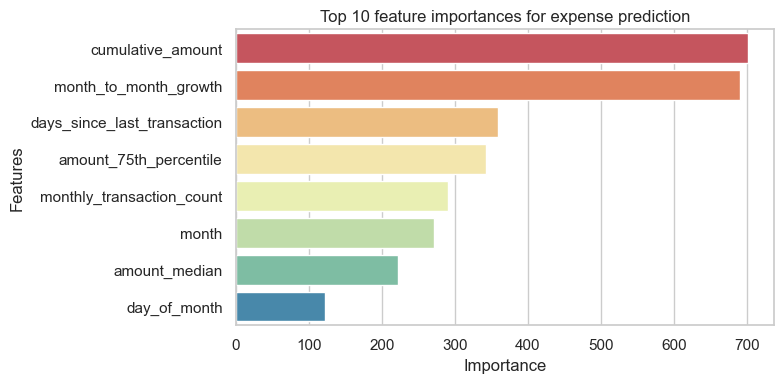

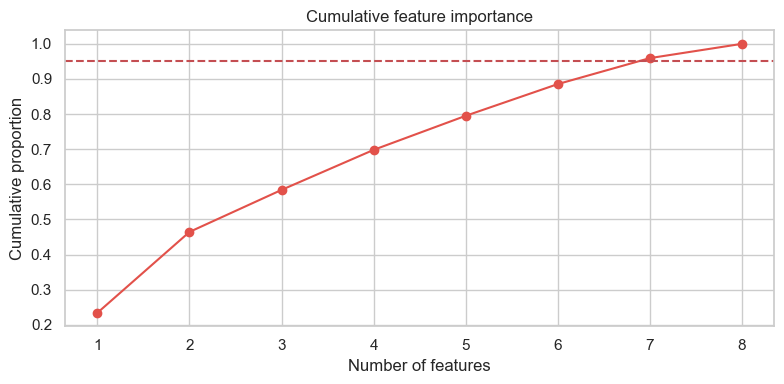

In [308]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Diff models to evaluate
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'ElasticNet': ElasticNet(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42)}

# store them to a dict
results = {}

# Perform cross-validation
for name, model in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    
    cv_scores = cross_val_score(pipe, X_train_expense, y_train_expense, cv=kf, scoring='r2')
    results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()}
    print(f"{name}: R² = {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# select the best performing model
best_model_name = max(results, key=lambda x: results[x]['cv_mean'])
print(f"\nBest model: {best_model_name}")

# Fit the best model on full training data
best_model = models[best_model_name]
pipe = Pipeline([('scaler', StandardScaler()), ('model', best_model)])

pipe.fit(X_train_expense, y_train_expense)

# validation data
X_valid_expense = valid_expense.drop(['user_id', 'amount_n26_currency'], axis=1)
y_valid_expense = np.log1p(valid_expense['amount_n26_currency'])

# predict on validation data
y_pred_log = pipe.predict(X_valid_expense)
y_pred = np.expm1(y_pred_log)
y_valid_orig = np.expm1(y_valid_expense)

# mertrics 
r2 = r2_score(y_valid_orig, y_pred)
mae = mean_absolute_error(y_valid_orig, y_pred)
mape = np.mean(np.abs((y_valid_orig - y_pred) / (y_valid_orig + 1))) * 100

print("\nValidation performance:")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

# Feature importance Analysis
if hasattr(pipe.named_steps['model'], 'feature_importances_'):
    importances = pipe.named_steps['model'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': X_train_expense.columns,
        'importance': importances}).sort_values('importance', ascending=False)
    
    total_importance = feature_importance_df['importance'].sum()
    feature_importance_df['cumulative_proportion'] = np.cumsum(feature_importance_df['importance']) / total_importance
    
    print("\nTop Features:")
    print(feature_importance_df)
    
    # visualization of feature importances
    plt.figure(figsize=(6, 4))
    sns.barplot(x='importance', y='feature', 
                data=feature_importance_df.head(10), 
                palette='Spectral')
    plt.title('Top 10 feature importances for expense prediction', fontsize=12)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tight_layout()
    plt.show()

# cumulative importance plot
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(feature_importance_df) + 1), 
         feature_importance_df['cumulative_proportion'], 
         marker='o')
plt.title('Cumulative feature importance', fontsize=12)
plt.xlabel('Number of features', fontsize=12)
plt.ylabel('Cumulative proportion', fontsize=12)
plt.axhline(y=0.95, color='r', linestyle='--')
plt.tight_layout()
plt.show()


July Expense Data Performance:
R²: 0.8327
MAE: 91.82
MAPE: 43.97%
RMSLE: 0.47%


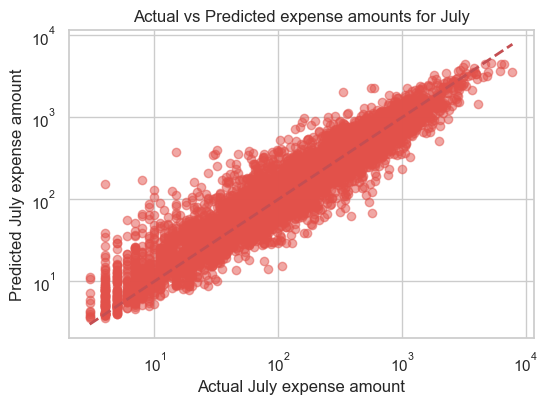

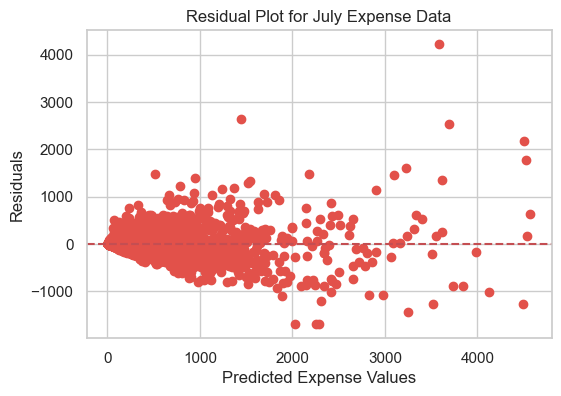

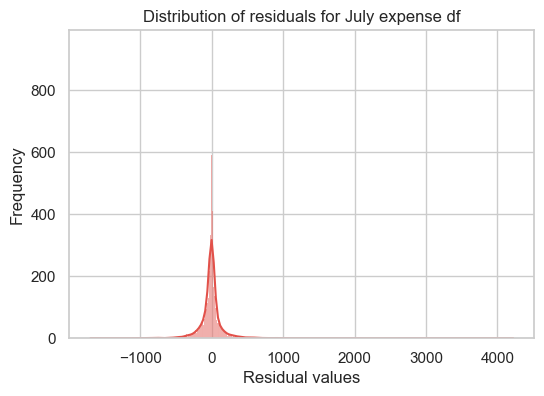

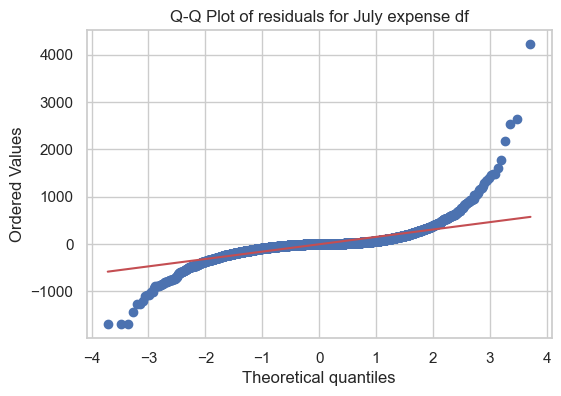

In [320]:
# doing the same evaluation for expense df on july set as a baseline

july_expense_data = valid_expense.copy()
X_july_expense = july_expense_data.drop(['user_id', 'amount_n26_currency'], axis=1)
y_july_expense = np.log1p(july_expense_data['amount_n26_currency'])

X_july_expense_scaled = pipe.named_steps['scaler'].transform(X_july_expense)

# predict on July expense 
y_pred_july_expense_log = pipe.named_steps['model'].predict(X_july_expense_scaled)
y_pred_july_expense = np.expm1(y_pred_july_expense_log)
y_july_expense_orig = np.expm1(y_july_expense)

# evaluate performance on July expense
r2_july_expense = r2_score(y_july_expense_orig, y_pred_july_expense)
mae_july_expense = mean_absolute_error(y_july_expense_orig, y_pred_july_expense)
mape_july_expense = np.mean(np.abs((y_july_expense_orig - y_pred_july_expense) / (y_july_expense_orig + 1))) * 100
rmsle_july_expense = np.sqrt(np.mean((y_july_expense - y_pred_july_expense_log)**2))

print("\nJuly Expense Data Performance:")
print(f"R²: {r2_july_expense:.4f}")
print(f"MAE: {mae_july_expense:.2f}")
print(f"MAPE: {mape_july_expense:.2f}%")
print(f"RMSLE: {rmsle_july_expense:.2f}%")

# Visualization of actual vs predicted for July Expenses
plt.figure(figsize=(6, 4))
plt.scatter(y_july_expense_orig, y_pred_july_expense, alpha=0.5)
plt.plot([y_july_expense_orig.min(), y_july_expense_orig.max()], 
         [y_july_expense_orig.min(), y_july_expense_orig.max()], 
         'r--', lw=2)

plt.xlabel('Actual July expense amount')
plt.ylabel('Predicted July expense amount')
plt.title('Actual vs Predicted expense amounts for July')
plt.xscale('log')
plt.yscale('log')
plt.show()

# Residual analysis for July Expenses
residuals_july_expense = y_july_expense_orig - y_pred_july_expense
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_july_expense, residuals_july_expense)
plt.xlabel('Predicted Expense Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for July Expense Data')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Distribution of residuals
plt.figure(figsize=(6, 4))
sns.histplot(residuals_july_expense, kde=True)
plt.title('Distribution of residuals for July expense df')
plt.xlabel('Residual values')
plt.ylabel('Frequency')
plt.show()

# Q-Q Plot for normality of residuals
plt.figure(figsize=(6, 4))
stats.probplot(residuals_july_expense, plot=plt)
plt.title('Q-Q Plot of residuals for July expense df')
plt.show()